In [1]:
%load_ext autoreload
%autoreload 2

# Weak Supervision VAE

Implementing some version of [Weak Supervision Variational Auto-Encoder](https://openreview.net/forum?id=0oDzoRjrbj) by Tonolini et al. 

There are some differences with the paper especially around the decoders and its still a work-in-progress as its mainly tested around the census data at the moment.

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch

import flippers

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.utils import load_wrench_dataset, MetricsUtil

M = {}

Choose your dataset here

In [6]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
dataset = "cdr"

data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [7]:
L_train.shape

(8430, 33)

In [8]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.6673913043478261, 0.33260869565217394]

In [9]:
polarities

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [10]:
flippers.summary(L_train, polarities)

,polarity,coverage,confidence,overlaps,matches,conflicts
0,1,0.032,1.0,0.028,0.026,0.013
1,1,0.022,1.0,0.018,0.018,0.006
2,1,0.004,1.0,0.004,0.004,0.002
3,0,0.048,1.0,0.048,0.048,0.020
4,0,0.088,1.0,0.087,0.087,0.038
5,0,0.188,1.0,0.170,0.145,0.092
6,0,0.014,1.0,0.014,0.013,0.009
7,1,0.018,1.0,0.018,0.018,0.005
8,1,0.020,1.0,0.020,0.020,0.008
9,0,0.047,1.0,0.047,0.047,0.017


Scoring utils:

In [11]:
y_test = test["label"].astype(int).values

In [12]:
Metrics = MetricsUtil(y_test, L_test)

# Training Label Models

## Majority Vote Model

In [13]:
from flippers.models import Voter

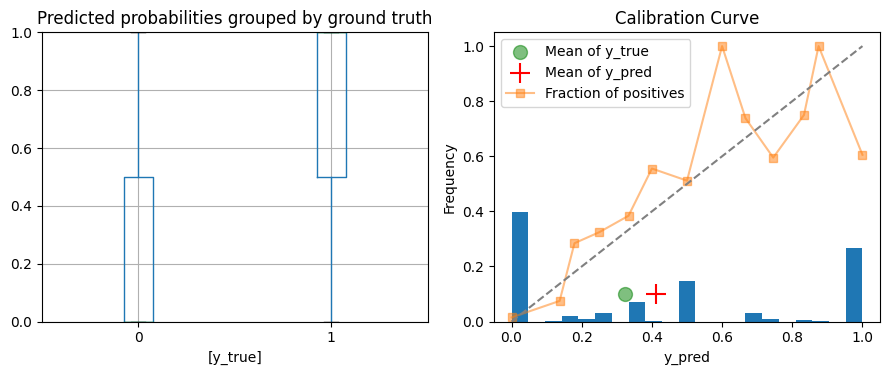

{'F1': 0.613,
 'Average_Precision': 0.59,
 'AUC': 0.828,
 'Accuracy': 0.753,
 'Balanced_Accuracy': 0.714}

In [14]:
preds_vote = Voter(polarities)
Metrics.score(preds_vote, name="MV")

## `flippers`' Snorkel Model

In [15]:
from flippers.models import SnorkelModel

In [16]:
m = SnorkelModel(polarities=polarities, class_balances=class_balances)
m.fit(L_train, learning_rate=1e-3, k=5e-3, num_epochs=10)

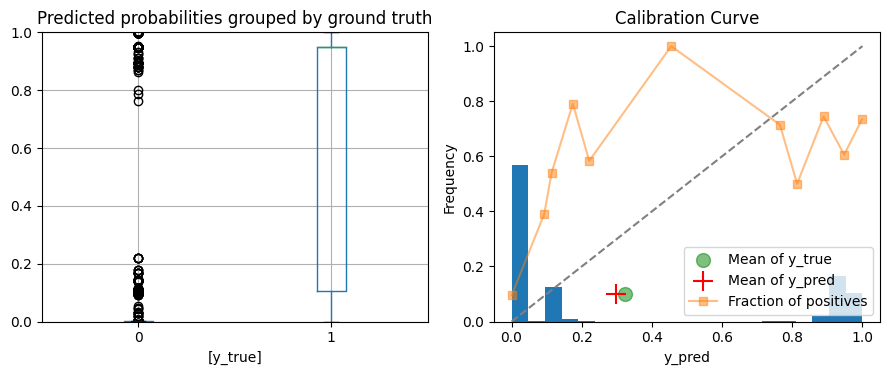

{'F1': 0.63,
 'Average_Precision': 0.656,
 'AUC': 0.853,
 'Accuracy': 0.772,
 'Balanced_Accuracy': 0.727}

In [17]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
Metrics.score(m, name="flippers")

# Weak Label VAE

In [48]:
from flippers.models._vae import WeakLabelVAE

Epoch [10/10]: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it, Loss=6.0]


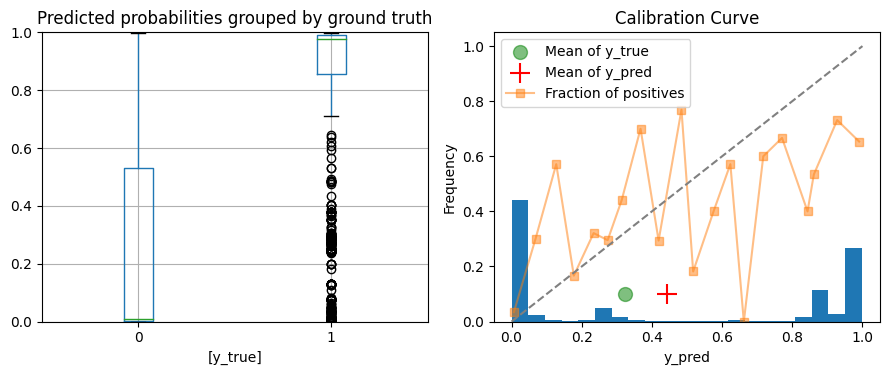

{'F1': 0.705,
 'Average_Precision': 0.643,
 'AUC': 0.851,
 'Accuracy': 0.775,
 'Balanced_Accuracy': 0.79}

In [81]:
m = WeakLabelVAE(polarities=polarities, class_balances=class_balances).to("cuda")
m.fit(L_train, learning_rate=1e-3, nudge=0.5)
Metrics.score(m, name="WeakLabelVAE")